<a href="https://colab.research.google.com/github/GabyDs/FirearmShotDetectionSystem/blob/main/FirearmShotDetectionSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import csv

import scipy
from scipy import signal

import matplotlib.pyplot as plt

import librosa, librosa.display
import IPython.display as ipd


# Dataset

In [2]:
!wget -c --no-check-certificate "https://drive.google.com/u/0/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t" -O train.zip

--2023-12-22 16:30:10--  https://drive.google.com/u/0/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t
Resolving drive.google.com (drive.google.com)... 108.177.97.138, 108.177.97.101, 108.177.97.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.97.138|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t [following]
--2023-12-22 16:30:11--  https://drive.google.com/uc?id=1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw&confirm=t
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lvor5qpko8v066sasf8i620rhacr09gd/1703262600000/12225850433951268217/*/1AFySnqxTCFhdeZZ02XpbUStgJyZoAirw?uuid=e8716ac7-6d58-4096-84ed-e3e6cd891a8f [following]
--2023-12-22 16:30:12--  https://doc-0g-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7

In [3]:
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: Audios_disparos_selva/val/fondo/5AD0E52D.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0EAF2.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0EEC0.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F031.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F069.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F06B.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F07C.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F08C.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F41A.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F47E.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0F89D.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0FB05.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD0FF9F.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD106B9.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD10E89.WAV  
  inflating: Audios_disparos_selva/val/fondo/5AD1

# Explore Dataset

In [30]:
def plot_spectrogram(shoot, back):

  fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

  spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(shoot)))
  img = librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', ax=ax[0])
  ax[0].set(title='Log-frequency power spectrogram to shoot')
  ax[0].label_outer()

  spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(back)))
  librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', ax=ax[1])
  ax[1].set(title='Log-frequency power spectrogram to background')
  ax[1].label_outer()

  fig.colorbar(img, ax=ax, format='%+2.f dB')


In [89]:
def plot_fft(shoot, back):

  # Calculate FFT
  shoot_fft = np.fft.fft(shoot)
  back_fft = np.fft.fft(back)

  shoot_mag = np.abs(shoot_fft)
  shoot_len = len(shoot_mag)

  back_mag = np.abs(back_fft)
  back_len = len(back_mag)

  duration = np.linspace(0, shoot_len, shoot_len)

  # Visualize FFT
  fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

  ax[0].plot(duration, shoot_mag)
  ax[0].set(title='FFT Graph of Shoot Audio')

  ax[1].plot(duration, back_mag)
  ax[1].set(title='FFT Graph of Background Audio')

  fig.supxlabel('Frequency [Hz]')
  fig.supylabel('Amplitude')

In [18]:
shoot_dir = '/content/Audios_disparos_selva/train/disparos'
background_dir = '/content/Audios_disparos_selva/train/fondo'

shoot_names = np.array(os.listdir(shoot_dir))
background_names = np.array(os.listdir(background_dir))

In [54]:
shoot_path = os.path.join(shoot_dir, np.random.choice(shoot_names))
back_path = os.path.join(background_dir, np.random.choice(background_names))

In [55]:
# shoot
shoot_sound, shoot_sr = librosa.load(shoot_path)

In [56]:
ipd.Audio(shoot_sound, rate=shoot_sr)

In [57]:
# background
back_sound, back_sr = librosa.load(back_path)

In [58]:
ipd.Audio(back_sound, rate=back_sr)

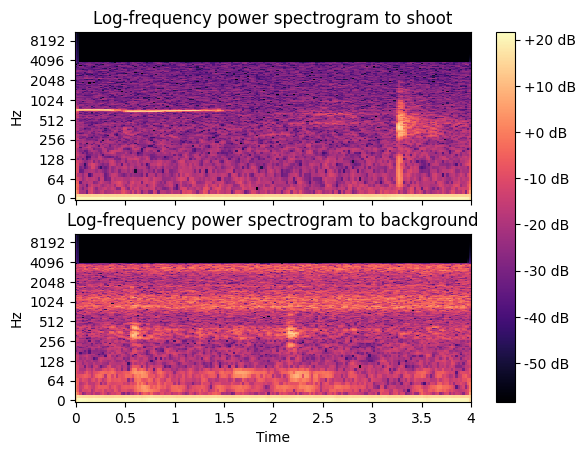

In [91]:
# display spectrogram
plot_spectrogram(shoot_sound, back_sound)

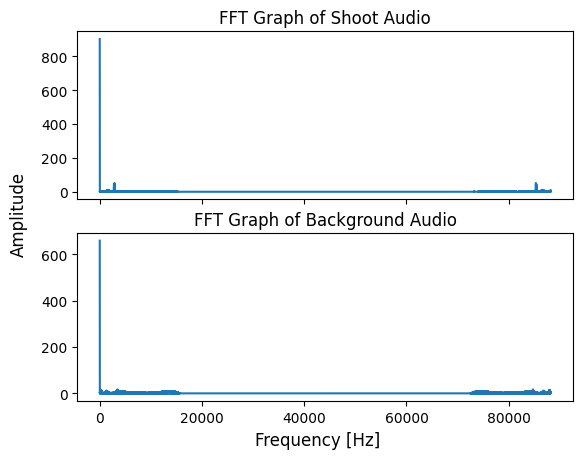

In [90]:
# display frequency response
plot_fft(shoot_sound, back_sound)